# Heterogeneous Transfer Learning for Highly non-linear regression tasks: without knowledge of the target ODE structure

This notebook presents the code and results for executing the proposed methods $\mathrm{DHTLM}$, $\mathrm{DHTLFT}$ and their competitors $\mathrm{MLP}$, $\mathrm{MLP}_\mathrm{init}$, $\mathrm{FTLL}$, and $\mathrm{FTLL}_\mathrm{tire}$ on both simulated and real datasets. The same training strategy for the proposed methods is used for the competitors. Although we provide the code for executing the different combinations (different hyperparameters, training sizes, folds, and so on), executing them on a standard computer is computationally expensive. Our solution (as mentioned in the paper) was using our Linux server and launching different jobs in parallel, each containing one combination (since the different combinations are independent). Due to job submission limitations, even this solution took quite some time. The execution time, however, is far less than that of HBTL and its competitors (with knowledge of the target ODE structure). The final results (in csv format, which contain prediction errors on the test sets and the min-max intervals) are saved and provided for visualization → see the folder Final_results_csv_files.

In [ ]:
import pandas as pd
import os, sys
import kennard_stone as ks
import seaborn as sns
import torch
import glob

# Get the current working directory (where the notebook is)
current_dir = os.getcwd()

# Add the parent directory to sys.path (where hck_tools and python_files are)
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(parent_dir)

from python_files.Plot_functions import *
from python_files.Deep_Transfer_functions import * # This file "Deep_Transfer_functions" contain the neural networks functions used to perform our MLP based methods and thei competitors
                                          
from python_files.utils import * 

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # device
criterion = CustomLoss() # training and validaiton loss; help to prevent larger output nitrogen values from disproportionately influencing the model compared to smaller ones during parameter optimization 

# Source simulated data set

In [ ]:
# Data loading
source_sim = pd.read_csv("Simulated_datasets/source_10000.csv")
source_sim = source_sim[["T", "ppH2", "LHSV", "Res0", "N0", "S0", "TMP", "N_simul"]]

# Source preprocessing
source_features_nn_sim = source_sim.drop(columns=["N_simul"])
source_output_nn_sim = source_sim["N_simul"].abs()
X_source_nn_sim = source_features_nn_sim.to_numpy()
y_source_nn_sim = source_output_nn_sim.to_numpy()

X_train_source_nn_sim, X_test_source_nn_sim, y_train_source_nn_sim, y_test_source_nn_sim = ks.train_test_split(
    X_source_nn_sim, y_source_nn_sim, test_size=1) # Can be removed. The source test serves mainly to visualize the performance of the pre-trained source MLP used to initialize the proposed methods and the competitors (except for MLP).
X_train_source_nn_sim, X_val_source_nn_sim, y_train_source_nn_sim, y_val_source_nn_sim = ks.train_test_split(
    X_train_source_nn_sim, y_train_source_nn_sim, test_size=1000)

# Source data normalization and tensor conversion
source_scaler = StandardScaler()
X_train_source_nn_norm_sim = source_scaler.fit_transform(X_train_source_nn_sim)
X_val_source_nn_norm_sim = source_scaler.transform(X_val_source_nn_sim)
X_test_source_nn_norm_sim = source_scaler.transform(X_test_source_nn_sim)

X_train_source_sim = torch.tensor(X_train_source_nn_norm_sim, dtype=torch.float64).to(device)
X_val_source_sim = torch.tensor(X_val_source_nn_norm_sim, dtype=torch.float64).to(device)
X_test_source_sim = torch.tensor(X_test_source_nn_norm_sim, dtype=torch.float64).to(device)

y_train_source_sim = torch.tensor(y_train_source_nn_sim, dtype=torch.float64).reshape(-1, 1).to(device)
y_val_source_sim = torch.tensor(y_val_source_nn_sim, dtype=torch.float64).reshape(-1, 1).to(device)
y_test_source_sim = torch.tensor(y_test_source_nn_sim, dtype=torch.float64).reshape(-1, 1).to(device) # Optional

2025-10-30 11:47:59,689 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.

2025-10-30 11:48:00,565 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.

2025-10-30 11:48:06,972 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.

2025-10-30 11:48:07,775 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.



# Source real data set

In [ ]:
# Data loading
source_real= pd.read_csv("Real_datasets/source_vgo.csv")
source_real= source_real[["T", "ppH2", "LHSV", "Res0", "N0", "S0", "TMP", "Azote_liqTot"]]

# Source preprocessing
source_features_nn_real= source_real.drop(columns=["Azote_liqTot"])
source_output_nn_real= source_real["Azote_liqTot"].abs()
X_source_nn_real= source_features_nn_real.to_numpy()
y_source_nn_real= source_output_nn_real.to_numpy()

X_train_source_nn_real, X_test_source_nn_real, y_train_source_nn_real, y_test_source_nn_real= ks.train_test_split(
    X_source_nn_real, y_source_nn_real, test_size=1) # Can be removed. The source test serves mainly to visualize the performance of the pre-trained source MLP used to initialize the proposed methods and the competitors (except for MLP).
X_train_source_nn_real, X_val_source_nn_real, y_train_source_nn_real, y_val_source_nn_real= ks.train_test_split(
    X_train_source_nn_real, y_train_source_nn_real, test_size=10)

# Source data normalization and tensor conversion
source_scaler = StandardScaler()
X_train_source_nn_norm_real= source_scaler.fit_transform(X_train_source_nn_real)
X_val_source_nn_norm_real= source_scaler.transform(X_val_source_nn_real)
X_test_source_nn_norm_real= source_scaler.transform(X_test_source_nn_real)

X_train_source_real= torch.tensor(X_train_source_nn_norm_real, dtype=torch.float64).to(device)
X_val_source_real= torch.tensor(X_val_source_nn_norm_real, dtype=torch.float64).to(device)
X_test_source_real= torch.tensor(X_test_source_nn_norm_real, dtype=torch.float64).to(device)

y_train_source_real= torch.tensor(y_train_source_nn_real, dtype=torch.float64).reshape(-1, 1).to(device)
y_val_source_real= torch.tensor(y_val_source_nn_real, dtype=torch.float64).reshape(-1, 1).to(device)
y_test_source_real= torch.tensor(y_test_source_nn_real, dtype=torch.float64).reshape(-1, 1).to(device) # Optional

2025-10-30 11:48:17,177 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.

2025-10-30 11:48:17,178 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.

2025-10-30 11:48:17,183 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.

2025-10-30 11:48:17,184 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.



# Target real data set

In [ ]:
target_real = pd.read_csv(f"Real_datasets/pilot_pivot_co.csv")
target_real = target_real[["T", "ppH2", "LHSV", "Res0", "N0", "S0", "TMP", "Tire", "Azote_liqTot"]]
# Target preprocessing  
target_features_nn_real = target_real.drop(columns=["Azote_liqTot"])
target_output_nn_real = target_real["Azote_liqTot"]
X_target_nn_real = target_features_nn_real.to_numpy()
y_target_nn_real = target_output_nn_real.to_numpy()

## DHTLM

### Simulated data sets

In [ ]:
base_path_dhtlm = 'Results_simulated_data/DHTLM'  
# Création des répertoires et fichiers
for base in range(20):
    target_sim_iter = pd.read_csv(f"Simulated_datasets/Target_data_sets/target_base{base}.csv")
    target_sim_iter = target_sim_iter[["T", "ppH2", "LHSV", "Res0", "N0", "S0", "TMP", "Tire","N_simul"]]
    base_dir = os.path.join(base_path_dhtlm, f'base_{base}')
    os.makedirs(base_dir, exist_ok=True)
    for train in range(5, 105, 5):
        # Target preprocessing  
        target_features_nn_sim = target_sim_iter.drop(columns=["N_simul"])
        target_output_nn_sim = target_sim_iter["N_simul"]
        X_target_nn_sim = target_features_nn_sim.to_numpy()
        y_target_nn_sim = target_output_nn_sim.to_numpy()
        train_dir = os.path.join(base_dir, f'train={train}')
        os.makedirs(train_dir, exist_ok=True)

        X_train_target_nn_sim, X_test_target_nn_sim, y_train_target_nn_sim, y_test_target_nn_sim = ks.train_test_split(
            X_target_nn_sim, y_target_nn_sim, test_size=len(X_target_nn_sim)-train)

        study = run_optimization_unified(
            method='DHTLM',
            X_train_source=X_train_source_sim, 
            y_train_source=y_train_source_sim, 
            X_val_source=X_val_source_sim, 
            y_val_source=y_val_source_sim,
            X_test_source=X_test_source_sim, 
            y_test_source=y_test_source_sim, 
            X_train_target=X_train_target_nn_sim, 
            y_train_target=y_train_target_nn_sim,
            X_test_target=X_test_target_nn_sim, 
            y_test_target=y_test_target_nn_sim, 
            criterion=criterion, 
            train_dir=train_dir,
            base_index=base,
            train_size=train,
            index_name = 'base_index',
            device=device
        )
# Once all different combination results are obtained, now we concatenate 
# all the frame_results into one data frame so we can compute average test score and 
# min-max intervals.

# Find all CSV files
csv_files = glob.glob(os.path.join(base_path_dhtlm, '**/frame_results.csv'), recursive=True)
print(f"Found {len(csv_files)} CSV files")

# Read and concatenate all CSV files
dfs_list = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs_list.append(df)
consolidated_df_sim = pd.concat(dfs_list, ignore_index=True)

# Calculate mean test scores across different training sizes and datasets, with min-max intervals
mean_scores_dhtlm_sim = consolidated_df_sim.groupby(["train_size"]).agg(
    MAE_test=("MAE_test", "mean"),  
    lower_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 2.5)),
    upper_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 97.5)),
).reset_index()

output_file = os.path.join('Final_results_csv_files', 'DHTLM_sim_consolidated.csv') 
mean_scores_dhtlm_sim.to_csv(output_file, index=False)
print("Done!")

### Real data sets

In [ ]:
seed_path_dhtlm = 'Results_real_data/DHTLM'  
# Création des répertoires et fichiers
for seed in range(20):
    seed_dir = os.path.join(seed_path_dhtlm, f'seed_{seed}')
    os.makedirs(seed_dir, exist_ok=True)
    for train in range(5, 105, 5):
        train_dir = os.path.join(seed_dir, f'train={train}')
        os.makedirs(train_dir, exist_ok=True)

        X_train_target_nn_real, X_test_target_nn_real, y_train_target_nn_real, y_test_target_nn_real = train_test_split(
            X_target_nn_real, y_target_nn_real, test_size=len(X_target_nn_real)-train, random_state=seed)

        study = run_optimization_unified(
            method='DHTLM',
            X_train_source=X_train_source_real, 
            y_train_source=y_train_source_real, 
            X_val_source=X_val_source_real, 
            y_val_source=y_val_source_real,
            X_test_source=X_test_source_real, 
            y_test_source=y_test_source_real, 
            X_train_target=X_train_target_nn_real, 
            y_train_target=y_train_target_nn_real,
            X_test_target=X_test_target_nn_real, 
            y_test_target=y_test_target_nn_real, 
            criterion=criterion, 
            train_dir=train_dir,
            base_index=seed,
            train_size=train,
            index_name = 'seed_index',
            device=device
        )

# Find all CSV files
csv_files = glob.glob(os.path.join(seed_path_dhtlm, '**/frame_results.csv'), recursive=True)
print(f"Found {len(csv_files)} CSV files")

# Read and concatenate all CSV files
dfs_list = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs_list.append(df)
consolidated_df_real = pd.concat(dfs_list, ignore_index=True)

# Calculate mean test scores across different training sizes and datasets, with min-max intervals
mean_scores_dhtlm_real = consolidated_df_real.groupby(["train_size"]).agg(
    MAE_test=("MAE_test", "mean"),  
    lower_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 2.5)),
    upper_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 97.5)),
).reset_index()

output_file = os.path.join('Final_results_csv_files', 'DHTLM_real_consolidated.csv') 
mean_scores_dhtlm_real.to_csv(output_file, index=False)
print("Done!")

## DHTLFT

### Simulated data sets

In [ ]:
base_path_dhtlft = 'Results_simulated_data/DHTLFT'  
# Création des répertoires et fichiers
for base in range(20):
    target_sim_iter = pd.read_csv(f"Simulated_datasets/Target_data_sets/target_base{base}.csv")
    target_sim_iter = target_sim_iter[["T", "ppH2", "LHSV", "Res0", "N0", "S0", "TMP", "Tire", "N_simul"]]
    base_dir = os.path.join(base_path_dhtlft, f'base_{base}')
    os.makedirs(base_dir, exist_ok=True)
    for train in range(5, 105, 5):
        # Target preprocessing  
        target_features_nn_sim = target_sim_iter.drop(columns=["N_simul"])
        target_output_nn_sim = target_sim_iter["N_simul"]
        X_target_nn_sim = target_features_nn_sim.to_numpy()
        y_target_nn_sim = target_output_nn_sim.to_numpy()
        train_dir = os.path.join(base_dir, f'train={train}')
        os.makedirs(train_dir, exist_ok=True)

        X_train_target_nn_sim, X_test_target_nn_sim, y_train_target_nn_sim, y_test_target_nn_sim = ks.train_test_split(
            X_target_nn_sim, y_target_nn_sim, test_size=len(X_target_nn_sim)-train)

        study = run_optimization_unified(
            method='DHTLFT',
            X_train_source=X_train_source_sim, 
            y_train_source=y_train_source_sim, 
            X_val_source=X_val_source_sim, 
            y_val_source=y_val_source_sim,
            X_test_source=X_test_source_sim, 
            y_test_source=y_test_source_sim, 
            X_train_target=X_train_target_nn_sim, 
            y_train_target=y_train_target_nn_sim,
            X_test_target=X_test_target_nn_sim, 
            y_test_target=y_test_target_nn_sim, 
            criterion=criterion, 
            train_dir=train_dir,
            base_index=base,
            train_size=train,
            index_name = 'base_index',
            device=device
        )

# Find all CSV files
csv_files = glob.glob(os.path.join(base_path_dhtlft, '**/frame_results.csv'), recursive=True)
print(f"Found {len(csv_files)} CSV files")

# Read and concatenate all CSV files
dfs_list = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs_list.append(df)
consolidated_df_sim = pd.concat(dfs_list, ignore_index=True)

# Calculate mean test scores across different training sizes and datasets, with min-max intervals
mean_scores_dhtlft_sim = consolidated_df_sim.groupby(["train_size"]).agg(
    MAE_test=("MAE_test", "mean"),  
    lower_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 2.5)),
    upper_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 97.5)),
).reset_index()

output_file = os.path.join('Final_results_csv_files', 'DHTLFT_sim_consolidated.csv') 
mean_scores_dhtlft_sim.to_csv(output_file, index=False)
print("Done!")
                

### Real data sets

In [ ]:
seed_path_dhtlft = 'Results_real_data/DHTLFT'  
# Création des répertoires et fichiers
for seed in range(20):
    seed_dir = os.path.join(seed_path_dhtlft, f'seed_{seed}')
    os.makedirs(seed_dir, exist_ok=True)
    for train in range(5, 105, 5):
        train_dir = os.path.join(base_dir, f'train={train}')
        os.makedirs(train_dir, exist_ok=True)

        X_train_target_nn_real, X_test_target_nn_real, y_train_target_nn_real, y_test_target_nn_real = train_test_split(
            X_target_nn_real, y_target_nn_real, test_size=len(X_target_nn_real)-train, random_state=seed)

        study = run_optimization_unified(
            method='DHTLFT',
            X_train_source=X_train_source_real, 
            y_train_source=y_train_source_real, 
            X_val_source=X_val_source_real, 
            y_val_source=y_val_source_real,
            X_test_source=X_test_source_real, 
            y_test_source=y_test_source_real, 
            X_train_target=X_train_target_nn_real, 
            y_train_target=y_train_target_nn_real,
            X_test_target=X_test_target_nn_real, 
            y_test_target=y_test_target_nn_real, 
            criterion=criterion, 
            train_dir=train_dir,
            base_index=seed,
            train_size=train,
            index_name = 'seed_index',
            device=device
        )

# Find all CSV files
csv_files = glob.glob(os.path.join(seed_path_dhtlft, '**/frame_results.csv'), recursive=True)
print(f"Found {len(csv_files)} CSV files")

# Read and concatenate all CSV files
dfs_list = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs_list.append(df)
consolidated_df_real = pd.concat(dfs_list, ignore_index=True)

# Calculate mean test scores across different training sizes and datasets, with min-max intervals
mean_scores_dhtlft_real = consolidated_df_real.groupby(["train_size"]).agg(
    MAE_test=("MAE_test", "mean"),  
    lower_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 2.5)),
    upper_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 97.5)),
).reset_index()

output_file = os.path.join('Final_results_csv_files', 'DHTLFT_real_consolidated.csv') 
mean_scores_dhtlft_real.to_csv(output_file, index=False)
print("Done!")

# The competitors

## Simulated data sets

### MLP

In [ ]:
base_path_mlp = 'Results_simulated_data/MLP'  
# Création des répertoires et fichiers
for base in range(20):
    target_sim_iter = pd.read_csv(f"Simulated_datasets/Target_data_sets/target_base{base}.csv")
    target_sim_iter = target_sim_iter[["T", "ppH2", "LHSV", "Res0", "N0", "S0", "TMP", "Tire", "N_simul"]]
    base_dir = os.path.join(base_path_mlp, f'base_{base}')
    os.makedirs(base_dir, exist_ok=True)
    for train in range(5, 105, 5):
        # Target preprocessing  
        target_features_nn_sim = target_sim_iter.drop(columns=["N_simul"])
        target_output_nn_sim = target_sim_iter["N_simul"]
        X_target_nn_sim = target_features_nn_sim.to_numpy()
        y_target_nn_sim = target_output_nn_sim.to_numpy()
        train_dir = os.path.join(base_dir, f'train={train}')
        os.makedirs(train_dir, exist_ok=True)

        X_train_target_nn_sim, X_test_target_nn_sim, y_train_target_nn_sim, y_test_target_nn_sim = ks.train_test_split(
            X_target_nn_sim, y_target_nn_sim, test_size=len(X_target_nn_sim)-train)

        study = run_optimization_unified(
            method='MLP',
            X_train_source=None, 
            y_train_source=None, 
            X_val_source=None, 
            y_val_source=None,
            X_test_source=None, 
            y_test_source=None, 
            X_train_target=X_train_target_nn_sim, 
            y_train_target=y_train_target_nn_sim,
            X_test_target=X_test_target_nn_sim, 
            y_test_target=y_test_target_nn_sim, 
            criterion=criterion, 
            train_dir=train_dir,
            base_index=base,
            train_size=train,
            index_name = 'base_index',
            device=device
        )

# Find all CSV files
csv_files = glob.glob(os.path.join(base_path_mlp, '**/frame_results.csv'), recursive=True)
print(f"Found {len(csv_files)} CSV files")

# Read and concatenate all CSV files
dfs_list = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs_list.append(df)
consolidated_df_sim = pd.concat(dfs_list, ignore_index=True)

# Calculate mean test scores across different training sizes and datasets, with min-max intervals
mean_scores_mlp_sim = consolidated_df_sim.groupby(["train_size"]).agg(
    MAE_test=("MAE_test", "mean"),  
    lower_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 2.5)),
    upper_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 97.5)),
).reset_index()

output_file = os.path.join('Final_results_csv_files', 'MLP_sim_consolidated.csv') 
mean_scores_mlp_sim.to_csv(output_file, index=False)
print("Done!")
                

### $\mathrm{MLP}_\mathrm{init}$

In [ ]:
base_path_mlp_init = 'Results_simulated_data/MLP_init'  
# Création des répertoires et fichiers
for base in range(20):
    target_sim_iter = pd.read_csv(f"Simulated_datasets/Target_data_sets/target_base{base}.csv")
    target_sim_iter = target_sim_iter[["T", "ppH2", "LHSV", "Res0", "N0", "S0", "TMP", "Tire"," N_simul"]]
    base_dir = os.path.join(base_path_mlp_init, f'base_{base}')
    os.makedirs(base_dir, exist_ok=True)
    for train in range(5, 105, 5):
        # Target preprocessing  
        target_features_nn_sim = target_sim_iter.drop(columns=["N_simul"])
        target_output_nn_sim = target_sim_iter["N_simul"]
        X_target_nn_sim = target_features_nn_sim.to_numpy()
        y_target_nn_sim = target_output_nn_sim.to_numpy()
        train_dir = os.path.join(base_dir, f'train={train}')
        os.makedirs(train_dir, exist_ok=True)

        X_train_target_nn_sim, X_test_target_nn_sim, y_train_target_nn_sim, y_test_target_nn_sim = ks.train_test_split(
            X_target_nn_sim, y_target_nn_sim, test_size=len(X_target_nn_sim)-train)

        study = run_optimization_unified(
            method='MLP_init',
            X_train_source=X_train_source_sim, 
            y_train_source=y_train_source_sim, 
            X_val_source=X_val_source_sim, 
            y_val_source=y_val_source_sim,
            X_test_source=X_test_source_sim, 
            y_test_source=y_test_source_sim, 
            X_train_target=X_train_target_nn_sim, 
            y_train_target=y_train_target_nn_sim,
            X_test_target=X_test_target_nn_sim, 
            y_test_target=y_test_target_nn_sim, 
            criterion=criterion, 
            train_dir=train_dir,
            base_index=base,
            train_size=train,
            index_name = 'base_index',
            device=device
        )
        
# Find all CSV files
csv_files = glob.glob(os.path.join(base_path_mlp_init, '**/frame_results.csv'), recursive=True)
print(f"Found {len(csv_files)} CSV files")

# Read and concatenate all CSV files
dfs_list = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs_list.append(df)
consolidated_df_sim = pd.concat(dfs_list, ignore_index=True)

# Calculate mean test scores across different training sizes and datasets, with min-max intervals
mean_scores_mlp_init_sim = consolidated_df_sim.groupby(["train_size"]).agg(
    MAE_test=("MAE_test", "mean"),  
    lower_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 2.5)),
    upper_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 97.5)),
).reset_index()

output_file = os.path.join('Final_results_csv_files', 'MLP_init_sim_consolidated.csv') 
mean_scores_mlp_init_sim.to_csv(output_file, index=False)
print("Done!")
                

### $\mathrm{FTLL}$

In [ ]:
base_path_ftll = 'Results_simulated_data/FTLL'  
# Création des répertoires et fichiers
for base in range(20):
    target_sim_iter = pd.read_csv(f"Simulated_datasets/Target_data_sets/target_base{base}.csv")
    target_sim_iter = target_sim_iter[["T", "ppH2", "LHSV", "Res0", "N0", "S0", "TMP", "Tire", "N_simul"]]
    base_dir = os.path.join(base_path_ftll, f'base_{base}')
    os.makedirs(base_dir, exist_ok=True)
    for train in range(5, 105, 5):
        # Target preprocessing  
        target_features_nn_sim = target_sim_iter.drop(columns=["N_simul"])
        target_output_nn_sim = target_sim_iter["N_simul"]
        X_target_nn_sim = target_features_nn_sim.to_numpy()
        y_target_nn_sim = target_output_nn_sim.to_numpy()
        train_dir = os.path.join(base_dir, f'train={train}')
        os.makedirs(train_dir, exist_ok=True)

        X_train_target_nn_sim, X_test_target_nn_sim, y_train_target_nn_sim, y_test_target_nn_sim = ks.train_test_split(
            X_target_nn_sim, y_target_nn_sim, test_size=len(X_target_nn_sim)-train)

        study = run_optimization_unified(
            method='FTLL',
            X_train_source=X_train_source_sim, 
            y_train_source=y_train_source_sim, 
            X_val_source=X_val_source_sim, 
            y_val_source=y_val_source_sim,
            X_test_source=X_test_source_sim, 
            y_test_source=y_test_source_sim, 
            X_train_target=X_train_target_nn_sim, 
            y_train_target=y_train_target_nn_sim,
            X_test_target=X_test_target_nn_sim, 
            y_test_target=y_test_target_nn_sim, 
            criterion=criterion, 
            train_dir=train_dir,
            base_index=base,
            train_size=train,
            index_name = 'base_index',
            device=device
        )

# Find all CSV files
csv_files = glob.glob(os.path.join(base_path_ftll, '**/frame_results.csv'), recursive=True)
print(f"Found {len(csv_files)} CSV files")

# Read and concatenate all CSV files
dfs_list = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs_list.append(df)
consolidated_df_sim = pd.concat(dfs_list, ignore_index=True)

# Calculate mean test scores across different training sizes and datasets, with min-max intervals
mean_scores_ftll_sim = consolidated_df_sim.groupby(["train_size"]).agg(
    MAE_test=("MAE_test", "mean"),  
    lower_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 2.5)),
    upper_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 97.5)),
).reset_index()

output_file = os.path.join('Final_results_csv_files', 'FTLL_sim_consolidated.csv') 
mean_scores_ftll_sim.to_csv(output_file, index=False)
print("Done!")     

### $\mathrm{FTLL}_\mathrm{tire}$

In [ ]:
base_path_ftll_tire = 'Results_simulated_data/FTLL_tire'  
# Création des répertoires et fichiers
for base in range(20):
    target_sim_iter = pd.read_csv(f"Simulated_datasets/Target_data_sets/target_base{base}.csv")
    target_sim_iter = target_sim_iter[["T", "ppH2", "LHSV", "Res0", "N0", "S0", "TMP", "Tire", "N_simul"]]
    base_dir = os.path.join(base_path_ftll_tire, f'base_{base}')
    os.makedirs(base_dir, exist_ok=True)
    for train in range(5, 105, 5):
        # Target preprocessing  
        target_features_nn_sim = target_sim_iter.drop(columns=["N_simul"])
        target_output_nn_sim = target_sim_iter["N_simul"]
        X_target_nn_sim = target_features_nn_sim.to_numpy()
        y_target_nn_sim = target_output_nn_sim.to_numpy()
        train_dir = os.path.join(base_dir, f'train={train}')
        os.makedirs(train_dir, exist_ok=True)

        X_train_target_nn_sim, X_test_target_nn_sim, y_train_target_nn_sim, y_test_target_nn_sim = ks.train_test_split(
            X_target_nn_sim, y_target_nn_sim, test_size=len(X_target_nn_sim)-train)

        study = run_optimization_unified(
            method='FTLL_tire',
            X_train_source=X_train_source_sim, 
            y_train_source=y_train_source_sim, 
            X_val_source=X_val_source_sim, 
            y_val_source=y_val_source_sim,
            X_test_source=X_test_source_sim, 
            y_test_source=y_test_source_sim, 
            X_train_target=X_train_target_nn_sim, 
            y_train_target=y_train_target_nn_sim,
            X_test_target=X_test_target_nn_sim, 
            y_test_target=y_test_target_nn_sim, 
            criterion=criterion, 
            train_dir=train_dir,
            base_index=base,
            train_size=train,
            index_name = 'base_index',
            device=device
        )

# Find all CSV files
csv_files = glob.glob(os.path.join(base_path_ftll_tire, '**/frame_results.csv'), recursive=True)
print(f"Found {len(csv_files)} CSV files")

# Read and concatenate all CSV files
dfs_list = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs_list.append(df)
consolidated_df_sim = pd.concat(dfs_list, ignore_index=True)

# Calculate mean test scores across different training sizes and datasets, with min-max intervals
mean_scores_ftll_tire_sim = consolidated_df_sim.groupby(["train_size"]).agg(
    MAE_test=("MAE_test", "mean"),  
    lower_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 2.5)),
    upper_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 97.5)),
).reset_index()

output_file = os.path.join('Final_results_csv_files', 'FTLL_tire_sim_consolidated.csv') 
mean_scores_ftll_tire_sim.to_csv(output_file, index=False)
print("Done!")   

## Real data sets

### MLP

In [ ]:
seed_path_mlp = 'Results_real_data/MLP'  
# Création des répertoires et fichiers
for seed in range(20):
    seed_dir = os.path.join(seed_path_mlp, f'seed_{seed}')
    os.makedirs(seed_dir, exist_ok=True)
    for train in range(5, 105, 5):
        train_dir = os.path.join(base_dir, f'train={train}')
        os.makedirs(train_dir, exist_ok=True)

        X_train_target_nn_real, X_test_target_nn_real, y_train_target_nn_real, y_test_target_nn_real = train_test_split(
            X_target_nn_real, y_target_nn_real, test_size=len(X_target_nn_real)-train, random_state=seed)

        study = run_optimization_unified(
            method='MLP',
            X_train_source=None, 
            y_train_source=None, 
            X_val_source=None, 
            y_val_source=None,
            X_test_source=None, 
            y_test_source=None, 
            X_train_target=X_train_target_nn_real, 
            y_train_target=y_train_target_nn_real,
            X_test_target=X_test_target_nn_real, 
            y_test_target=y_test_target_nn_real, 
            criterion=criterion, 
            train_dir=train_dir,
            base_index=seed,
            train_size=train,
            index_name = 'seed_index',
            device=device
        )

# Find all CSV files
csv_files = glob.glob(os.path.join(seed_path_mlp, '**/frame_results.csv'), recursive=True)
print(f"Found {len(csv_files)} CSV files")

# Read and concatenate all CSV files
dfs_list = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs_list.append(df)
consolidated_df_real = pd.concat(dfs_list, ignore_index=True)

# Calculate mean test scores across different training sizes and datasets, with min-max intervals
mean_scores_mlp_real = consolidated_df_real.groupby(["train_size"]).agg(
    MAE_test=("MAE_test", "mean"),  
    lower_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 2.5)),
    upper_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 97.5)),
).reset_index()

output_file = os.path.join('Final_results_csv_files', 'MLP_real_consolidated.csv') 
mean_scores_mlp_real.to_csv(output_file, index=False)
print("Done!")        

### $\mathrm{MLP}_\mathrm{init}$

In [ ]:
seed_path_mlp_init = 'Results_real_data/MLP_init'  
# Création des répertoires et fichiers
for seed in range(20):
    seed_dir = os.path.join(seed_path_mlp_init, f'seed_{seed}')
    os.makedirs(seed_dir, exist_ok=True)
    for train in range(5, 105, 5):
        train_dir = os.path.join(base_dir, f'train={train}')
        os.makedirs(train_dir, exist_ok=True)

        X_train_target_nn_real, X_test_target_nn_real, y_train_target_nn_real, y_test_target_nn_real = train_test_split(
            X_target_nn_real, y_target_nn_real, test_size=len(X_target_nn_real)-train, random_state=seed)

        study = run_optimization_unified(
            method='MLP_init',
            X_train_source=X_train_source_real, 
            y_train_source=y_train_source_real, 
            X_val_source=X_val_source_real, 
            y_val_source=y_val_source_real,
            X_test_source=X_test_source_real, 
            y_test_source=y_test_source_real, 
            X_train_target=X_train_target_nn_real, 
            y_train_target=y_train_target_nn_real,
            X_test_target=X_test_target_nn_real, 
            y_test_target=y_test_target_nn_real, 
            criterion=criterion, 
            train_dir=train_dir,
            base_index=seed,
            train_size=train,
            index_name = 'seed_index',
            device=device
        )

# Find all CSV files
csv_files = glob.glob(os.path.join(seed_path_mlp_init, '**/frame_results.csv'), recursive=True)
print(f"Found {len(csv_files)} CSV files")

# Read and concatenate all CSV files
dfs_list = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs_list.append(df)
consolidated_df_real = pd.concat(dfs_list, ignore_index=True)

# Calculate mean test scores across different training sizes and datasets, with min-max intervals
mean_scores_mlp_init_real = consolidated_df_real.groupby(["train_size"]).agg(
    MAE_test=("MAE_test", "mean"),  
    lower_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 2.5)),
    upper_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 97.5)),
).reset_index()

output_file = os.path.join('Final_results_csv_files', 'MLP_init_real_consolidated.csv') 
mean_scores_mlp_init_real.to_csv(output_file, index=False)
print("Done!")      

### $\mathrm{FTLL}$

In [ ]:
seed_path_ftll = 'Results_real_data/FTLL'  
# Création des répertoires et fichiers
for seed in range(20):
    seed_dir = os.path.join(seed_path_ftll, f'seed_{seed}')
    os.makedirs(seed_dir, exist_ok=True)
    for train in range(5, 105, 5):
        train_dir = os.path.join(base_dir, f'train={train}')
        os.makedirs(train_dir, exist_ok=True)

        X_train_target_nn_real, X_test_target_nn_real, y_train_target_nn_real, y_test_target_nn_real = train_test_split(
            X_target_nn_real, y_target_nn_real, test_size=len(X_target_nn_real)-train, random_state=seed)

        study = run_optimization_unified(
            method='FTLL',
            X_train_source=X_train_source_real, 
            y_train_source=y_train_source_real, 
            X_val_source=X_val_source_real, 
            y_val_source=y_val_source_real,
            X_test_source=X_test_source_real, 
            y_test_source=y_test_source_real, 
            X_train_target=X_train_target_nn_real, 
            y_train_target=y_train_target_nn_real,
            X_test_target=X_test_target_nn_real, 
            y_test_target=y_test_target_nn_real, 
            criterion=criterion, 
            train_dir=train_dir,
            base_index=seed,
            train_size=train,
            index_name = 'seed_index',
            device=device
        )

# Find all CSV files
csv_files = glob.glob(os.path.join(seed_path_ftll, '**/frame_results.csv'), recursive=True)
print(f"Found {len(csv_files)} CSV files")

# Read and concatenate all CSV files
dfs_list = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs_list.append(df)
consolidated_df_real = pd.concat(dfs_list, ignore_index=True)

# Calculate mean test scores across different training sizes and datasets, with min-max intervals
mean_scores_ftll_real = consolidated_df_real.groupby(["train_size"]).agg(
    MAE_test=("MAE_test", "mean"),  
    lower_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 2.5)),
    upper_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 97.5)),
).reset_index()

output_file = os.path.join('Final_results_csv_files', 'FTLL_real_consolidated.csv') 
mean_scores_ftll_real.to_csv(output_file, index=False)
print("Done!")   

### $\mathrm{FTLL}_\mathrm{tire}$

In [ ]:
seed_path_ftll_tire = 'Results_real_data/FTLL_tire'  
# Création des répertoires et fichiers
for seed in range(20):
    seed_dir = os.path.join(seed_path_ftll_tire, f'seed_{seed}')
    os.makedirs(seed_dir, exist_ok=True)
    for train in range(5, 105, 5):
        train_dir = os.path.join(base_dir, f'train={train}')
        os.makedirs(train_dir, exist_ok=True)

        X_train_target_nn_real, X_test_target_nn_real, y_train_target_nn_real, y_test_target_nn_real = train_test_split(
            X_target_nn_real, y_target_nn_real, test_size=len(X_target_nn_real)-train, random_state=seed)

        study = run_optimization_unified(
            method='FTLL_tire',
            X_train_source=X_train_source_real, 
            y_train_source=y_train_source_real, 
            X_val_source=X_val_source_real, 
            y_val_source=y_val_source_real,
            X_test_source=X_test_source_real, 
            y_test_source=y_test_source_real, 
            X_train_target=X_train_target_nn_real, 
            y_train_target=y_train_target_nn_real,
            X_test_target=X_test_target_nn_real, 
            y_test_target=y_test_target_nn_real, 
            criterion=criterion, 
            train_dir=train_dir,
            base_index=seed,
            train_size=train,
            index_name = 'seed_index',
            device=device
        )

# Find all CSV files
csv_files = glob.glob(os.path.join(seed_path_ftll_tire, '**/frame_results.csv'), recursive=True)
print(f"Found {len(csv_files)} CSV files")

# Read and concatenate all CSV files
dfs_list = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs_list.append(df)
consolidated_df_real = pd.concat(dfs_list, ignore_index=True)

# Calculate mean test scores across different training sizes and datasets, with min-max intervals
mean_scores_ftll_tire_real = consolidated_df_real.groupby(["train_size"]).agg(
    MAE_test=("MAE_test", "mean"),  
    lower_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 2.5)),
    upper_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 97.5)),
).reset_index()

output_file = os.path.join('Final_results_csv_files', 'FTLL_tire_real_consolidated.csv') 
mean_scores_ftll_tire_real.to_csv(output_file, index=False)
print("Done!")   

# Results

## Simulated data sets

In [3]:
##################################################################### DHTLM and DHTLFT and their competitors ####################################################################################
DHTLM_sim_results = pd.read_csv("Final_results_csv_files/DHTLM_sim_results.csv")
DHTLFT_sim_results = pd.read_csv("Final_results_csv_files/DHTLFT_sim_results.csv")
MLP_sim_results = pd.read_csv("Final_results_csv_files/MLP_sim_results.csv")
MLP_init_sim_results = pd.read_csv("Final_results_csv_files/MLP_init_sim_results.csv")
FTLL_sim_results = pd.read_csv("Final_results_csv_files/FTLL_sim_results.csv")
FTLL_tire_sim_results = pd.read_csv("Final_results_csv_files/FTLL_tire_sim_results.csv")

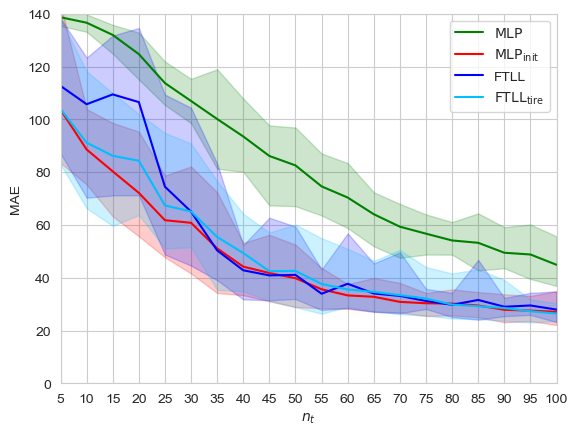

In [25]:
##################################################################### Competitors ####################################################################################
sns.set_style("whitegrid")
sns.lineplot(x=MLP_sim_results["train_size"], y=MLP_sim_results["MAE_test"], color="green", label="$\mathrm{MLP}$")
sns.lineplot(x=MLP_init_sim_results["train_size"], y=MLP_init_sim_results["MAE_test"], color="red", label="$\mathrm{MLP}_\mathrm{init}$")
sns.lineplot(x=FTLL_sim_results["train_size"], y=FTLL_sim_results["MAE_test"], color="blue", label="FTLL")
sns.lineplot(x=FTLL_tire_sim_results["train_size"], y=FTLL_tire_sim_results["MAE_test"], color="deepskyblue", label="$\mathrm{FTLL}_\mathrm{tire}$")


plt.fill_between(MLP_sim_results["train_size"], MLP_sim_results["lower_ci_mae_test"], 
                 MLP_sim_results["upper_ci_mae_test"], color="green", alpha=0.2)
plt.fill_between(MLP_init_sim_results["train_size"], MLP_init_sim_results["lower_ci_mae_test"], 
                 MLP_init_sim_results["upper_ci_mae_test"], color="red", alpha=0.2)
plt.fill_between(FTLL_sim_results["train_size"], FTLL_sim_results["lower_ci_mae_test"], 
                 FTLL_sim_results["upper_ci_mae_test"], color="blue", alpha=0.2)
plt.fill_between(FTLL_tire_sim_results["train_size"], FTLL_tire_sim_results["lower_ci_mae_test"], 
                 FTLL_tire_sim_results["upper_ci_mae_test"], color="deepskyblue", alpha=0.2)

train_sizes = list(range(5, 105, 5))
plt.xticks(train_sizes)
# ZOOM
plt.xlim(5, 100)  
plt.ylim(0, 140) 
plt.xlabel("$n_t$")
plt.ylabel("MAE")
plt.legend()
plt.savefig("Saved_figures/Sim_data_competitors_of_DHTLM_DHTLFT.pdf", bbox_inches="tight")
plt.show()

The best competitor $\mathrm{MLP}_\mathrm{init}$ is then compared to DHTLM and DHTLFT.

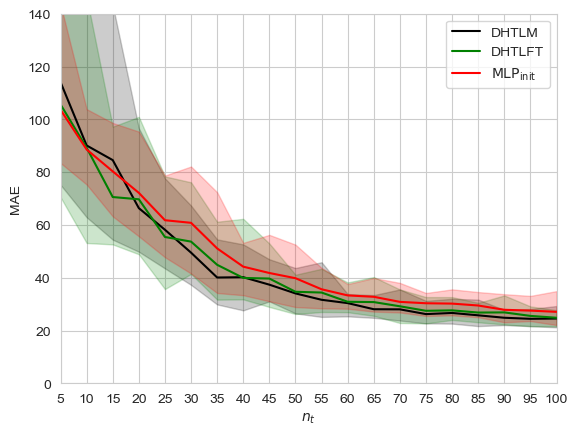

In [24]:
##################################################################### DHTLM and DHTLFT vs MLP_init ####################################################################################
sns.set_style("whitegrid")
sns.lineplot(x=DHTLM_sim_results["train_size"], y=DHTLM_sim_results["MAE_test"], color="black", label="DHTLM")
sns.lineplot(x=DHTLFT_sim_results["train_size"], y=DHTLFT_sim_results["MAE_test"], color="green", label="DHTLFT")
sns.lineplot(x=MLP_init_sim_results["train_size"], y=MLP_init_sim_results["MAE_test"], color="red", label="$\mathrm{MLP}_\mathrm{init}$")

plt.fill_between(DHTLM_sim_results["train_size"], DHTLM_sim_results["lower_ci_mae_test"], 
                 DHTLM_sim_results["upper_ci_mae_test"], color="black", alpha=0.2)
plt.fill_between(DHTLFT_sim_results["train_size"], DHTLFT_sim_results["lower_ci_mae_test"], 
                 DHTLFT_sim_results["upper_ci_mae_test"], color="green", alpha=0.2)
plt.fill_between(MLP_init_sim_results["train_size"], MLP_init_sim_results["lower_ci_mae_test"], 
                 MLP_init_sim_results["upper_ci_mae_test"], color="red", alpha=0.2)
train_sizes = list(range(5, 105, 5))
plt.xticks(train_sizes)
# ZOOM
plt.xlim(5, 100)  
plt.ylim(0, 140) 
plt.xlabel("$n_t$")
plt.ylabel("MAE")
plt.legend()
plt.savefig("Saved_figures/Sim_data_DHTLM_DHTLFT_vs_MLP_init.pdf", bbox_inches="tight")
plt.show()

## Real data set

In [16]:
DHTLM_real_results = pd.read_csv("Final_results_csv_files/DHTLM_real_results.csv")
DHTLFT_real_results = pd.read_csv("Final_results_csv_files/DHTLFT_real_results.csv")
MLP_real_results = pd.read_csv("Final_results_csv_files/MLP_real_results.csv")
MLP_init_real_results = pd.read_csv("Final_results_csv_files/MLP_init_real_results.csv")
FTLL_real_results = pd.read_csv("Final_results_csv_files/FTLL_real_results.csv")
FTLL_tire_real_results = pd.read_csv("Final_results_csv_files/FTLL_tire_real_results.csv")

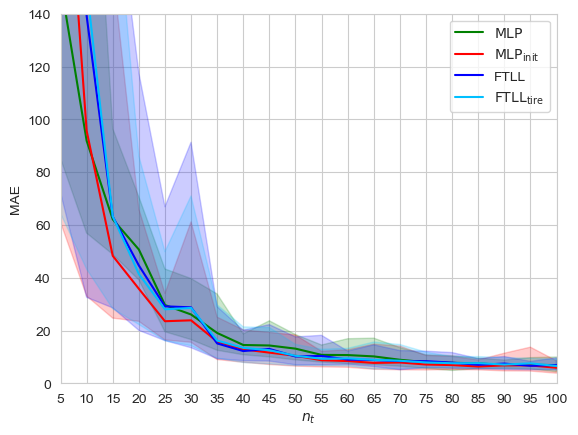

In [23]:
##################################################################### Competitors ####################################################################################
sns.set_style("whitegrid")
sns.lineplot(x=MLP_real_results["train_size"], y=MLP_real_results["MAE_test"], color="green", label="$\mathrm{MLP}$")
sns.lineplot(x=MLP_init_real_results["train_size"], y=MLP_init_real_results["MAE_test"], color="red", label="$\mathrm{MLP}_\mathrm{init}$")
sns.lineplot(x=FTLL_real_results["train_size"], y=FTLL_real_results["MAE_test"], color="blue", label="FTLL")
sns.lineplot(x=FTLL_tire_real_results["train_size"], y=FTLL_tire_real_results["MAE_test"], color="deepskyblue", label="$\mathrm{FTLL}_\mathrm{tire}$")


plt.fill_between(MLP_real_results["train_size"], MLP_real_results["lower_ci_mae_test"], 
                 MLP_real_results["upper_ci_mae_test"], color="green", alpha=0.2)
plt.fill_between(MLP_init_real_results["train_size"], MLP_init_real_results["lower_ci_mae_test"], 
                 MLP_init_real_results["upper_ci_mae_test"], color="red", alpha=0.2)
plt.fill_between(FTLL_real_results["train_size"], FTLL_real_results["lower_ci_mae_test"], 
                 FTLL_real_results["upper_ci_mae_test"], color="blue", alpha=0.2)
plt.fill_between(FTLL_tire_real_results["train_size"], FTLL_tire_real_results["lower_ci_mae_test"], 
                 FTLL_tire_real_results["upper_ci_mae_test"], color="deepskyblue", alpha=0.2)

train_sizes = list(range(5, 105, 5))
plt.xticks(train_sizes)
# ZOOM
plt.xlim(5, 100)  
plt.ylim(0, 140) 
plt.xlabel("$n_t$")
plt.ylabel("MAE")
plt.legend()
plt.savefig("Saved_figures/Real_data_competitors_of_DHTLM_DHTLFT.pdf", bbox_inches="tight")
plt.show()

The best competitor $\mathrm{MLP}_\mathrm{init}$ is then compared to DHTLM and DHTLFT.

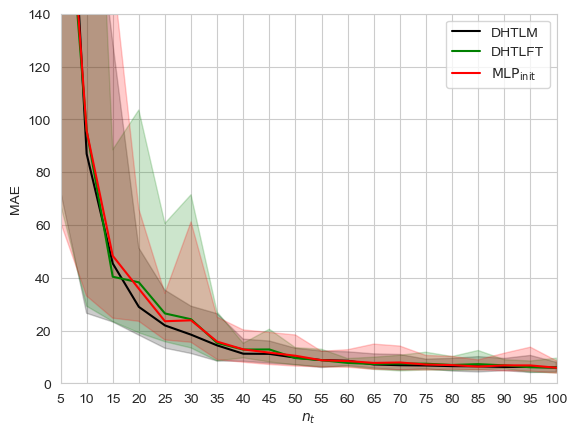

In [22]:
##################################################################### DHTLM and DHTLFT vs MLP_init ####################################################################################
sns.set_style("whitegrid")
sns.lineplot(x=DHTLM_real_results["train_size"], y=DHTLM_real_results["MAE_test"], color="black", label="DHTLM")
sns.lineplot(x=DHTLFT_real_results["train_size"], y=DHTLFT_real_results["MAE_test"], color="green", label="DHTLFT")
sns.lineplot(x=MLP_init_real_results["train_size"], y=MLP_init_real_results["MAE_test"], color="red", label="$\mathrm{MLP}_\mathrm{init}$")

plt.fill_between(DHTLM_real_results["train_size"], DHTLM_real_results["lower_ci_mae_test"], 
                 DHTLM_real_results["upper_ci_mae_test"], color="black", alpha=0.2)
plt.fill_between(DHTLFT_real_results["train_size"], DHTLFT_real_results["lower_ci_mae_test"], 
                 DHTLFT_real_results["upper_ci_mae_test"], color="green", alpha=0.2)
plt.fill_between(MLP_init_real_results["train_size"], MLP_init_real_results["lower_ci_mae_test"], 
                 MLP_init_real_results["upper_ci_mae_test"], color="red", alpha=0.2)
train_sizes = list(range(5, 105, 5))
plt.xticks(train_sizes)
# ZOOM
plt.xlim(5, 100)  
plt.ylim(0, 140) 
plt.xlabel("$n_t$")
plt.ylabel("MAE")
plt.legend()
plt.savefig("Saved_figures/Real_data_DHTLM_DHTLFT_vs_MLP_init.pdf", bbox_inches="tight")
plt.show()